In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from transformers import AutoTokenizer, DistilBertModel
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import time

/Users/mattelim/miniforge3/envs/6861/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# create a simple torch model with 1 fully connected layer

class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 2)

    def forward(self, x):
        # apply relu on the output of the fully connected layer
        # x = F.relu(self.fc1(x))
        x = self.fc1(x)
        return x

In [3]:
# load api key from secrets.json
import openai
import json

try:
    with open("secrets.json") as f:
        secrets = json.load(f)
    my_api_key = secrets["openai"]
    print("API key loaded.")
    openai.api_key = my_api_key
except FileNotFoundError:
    print("Secrets file not found. YOU NEED THEM TO RUN THIS.")

API key loaded.


In [4]:
timestamp = round(time.time())
print(f"Timestamp: {timestamp}")

Timestamp: 1702145671


## Create dataset

### ✋ Change the classification here ↓

In [5]:
classification = 'animal'

In [6]:
prompt = f"Please generate 300 unique {classification} words. The output MUST ONLY be a Python list of the words."
# prompt = f"Please generate 300 unique {classification} words. Please include the most common and familiar instances. The output MUST ONLY be a Python list of the words."

In [7]:
# model_num = "gpt-3.5-turbo-1106"
# model_num = "gpt-4-1106-preview"
model_num = "gpt-4"

completion = openai.ChatCompletion.create(
  model=model_num,
  messages=[
    {"role": "system", "content": "You are an expert category word generator."},
    {"role": "user", "content": prompt},
  ]
)

print(completion.choices[0].message)

# log the stringified output into a txt file by appending it to the end of the file
# with open("output.txt", "a") as f:
#   f.write(str(completion))

{
  "role": "assistant",
  "content": "[\"lion\", \"tiger\", \"cheetah\", \"leopard\", \"panther\", \"jaguar\", \"elephant\", \"giraffe\", \"rhinoceros\", \"hippopotamus\", \"zebra\", \"buffalo\", \"gazelle\", \"antelope\", \"wildebeest\", \"baboon\", \"monkey\", \"gorilla\", \"chimpanzee\", \"orangutan\", \"lemur\", \"koala\", \"kangaroo\", \"wombat\", \"platypus\", \"wallaby\", \"possum\", \"echidna\", \"dingo\", \"quokka\", \"emu\", \"cockatoo\", \"penguin\", \"seal\", \"whale\", \"dolphin\", \"shark\", \"octopus\", \"seahorse\", \"starfish\", \"jellyfish\", \"crab\", \"lobster\", \"shrimp\", \"clam\", \"oyster\", \"mussel\", \"squid\", \"turtle\", \"snake\", \"lizard\", \"crocodile\", \"alligator\", \"chameleon\", \"iguana\", \"gecko\", \"frog\", \"toad\", \"salamander\", \"newt\", \"butterfly\", \"moth\", \"beetle\", \"ant\", \"bee\", \"wasp\", \"spider\", \"scorpion\", \"cockroach\", \"grasshopper\", \"cricket\", \"worm\", \"snail\", \"slug\", \"termite\", \"mosquito\", \"fly\", 

In [11]:
words = eval(completion.choices[0].message.content)

# make sure that the output is a list of words
print(words)
print(words[0])

['lion', 'tiger', 'cheetah', 'leopard', 'panther', 'jaguar', 'elephant', 'giraffe', 'rhinoceros', 'hippopotamus', 'zebra', 'buffalo', 'gazelle', 'antelope', 'wildebeest', 'baboon', 'monkey', 'gorilla', 'chimpanzee', 'orangutan', 'lemur', 'koala', 'kangaroo', 'wombat', 'platypus', 'wallaby', 'possum', 'echidna', 'dingo', 'quokka', 'emu', 'cockatoo', 'penguin', 'seal', 'whale', 'dolphin', 'shark', 'octopus', 'seahorse', 'starfish', 'jellyfish', 'crab', 'lobster', 'shrimp', 'clam', 'oyster', 'mussel', 'squid', 'turtle', 'snake', 'lizard', 'crocodile', 'alligator', 'chameleon', 'iguana', 'gecko', 'frog', 'toad', 'salamander', 'newt', 'butterfly', 'moth', 'beetle', 'ant', 'bee', 'wasp', 'spider', 'scorpion', 'cockroach', 'grasshopper', 'cricket', 'worm', 'snail', 'slug', 'termite', 'mosquito', 'fly', 'dragonfly', 'ladybug', 'dove', 'sparrow', 'robin', 'cardinal', 'bluejay', 'crow', 'raven', 'hawk', 'eagle', 'falcon', 'condor', 'pelican', 'flamingo', 'swan', 'duck', 'goose', 'owl', 'parrot',

In [12]:
# change all strings to lowercase
words = [x.lower() for x in words]

print(words)

['lion', 'tiger', 'cheetah', 'leopard', 'panther', 'jaguar', 'elephant', 'giraffe', 'rhinoceros', 'hippopotamus', 'zebra', 'buffalo', 'gazelle', 'antelope', 'wildebeest', 'baboon', 'monkey', 'gorilla', 'chimpanzee', 'orangutan', 'lemur', 'koala', 'kangaroo', 'wombat', 'platypus', 'wallaby', 'possum', 'echidna', 'dingo', 'quokka', 'emu', 'cockatoo', 'penguin', 'seal', 'whale', 'dolphin', 'shark', 'octopus', 'seahorse', 'starfish', 'jellyfish', 'crab', 'lobster', 'shrimp', 'clam', 'oyster', 'mussel', 'squid', 'turtle', 'snake', 'lizard', 'crocodile', 'alligator', 'chameleon', 'iguana', 'gecko', 'frog', 'toad', 'salamander', 'newt', 'butterfly', 'moth', 'beetle', 'ant', 'bee', 'wasp', 'spider', 'scorpion', 'cockroach', 'grasshopper', 'cricket', 'worm', 'snail', 'slug', 'termite', 'mosquito', 'fly', 'dragonfly', 'ladybug', 'dove', 'sparrow', 'robin', 'cardinal', 'bluejay', 'crow', 'raven', 'hawk', 'eagle', 'falcon', 'condor', 'pelican', 'flamingo', 'swan', 'duck', 'goose', 'owl', 'parrot',

In [13]:
# remove duplicates
words = list(set(words))

print(len(words))

# assert len(list(set(words))) == len(words)

206


In [14]:
non_words = [
    "run", "jump", "eat", "sleep", "think", "happy", "fast", "slow", "beautiful", "smart",
    "quickly", "easily", "always", "never", "under", "over", "beside", "between", "through", "with",
    "and", "but", "or", "because", "although", "well", "yes", "no", "oh", "wow", "ouch",
    "go", "come", "stop", "start", "win", "lose", "hot", "cold", "loud", "soft",
    "bright", "dark", "high", "low", "near", "far", "big", "small", "old", "new",
    "first", "last", "next", "previous", "good", "bad", "happy", "sad", "rich", "poor",
    "early", "late", "hard", "easy", "simple", "complex", "right", "wrong", "true", "false",
    "up", "down", "in", "out", "on", "off", "up", "down", "here", "there",
    "now", "then", "today", "tomorrow", "yesterday", "soon", "later", "before", "after", "while",
    "once", "twice", "thrice", "nevertheless", "however", "suddenly", "finally", "quickly", "slowly", "nowadays",
    "some", "many", "few", "most", "none", "all", "each", "every", "somebody", "nobody",
    "something", "nothing", "somewhere", "nowhere", "anywhere", "everywhere", "this", "that", "these", "those",
    "which", "what", "who", "whom", "whose", "where", "when", "why", "how", "whether",
    "if", "unless", "because", "since", "although", "though", "while", "before", "after", "when",
    "and", "or", "but", "nor", "for", "so", "yet", "either", "neither", "however"
    "is", "are", "was", "were", "am", "be", "being", "been", "has", "have",
    "had", "do", "does", "did", "doing", "will", "would", "shall", "should", "can",
    "could", "may", "might", "must", "ought", "ain't", "isn't", "aren't", "wasn't", "weren't",
    "hasn't", "haven't", "hadn't", "don't", "doesn't", "didn't", "won't", "wouldn't", "shan't", "shouldn't",
    "can't", "cannot", "couldn't", "mayn't", "mightn't", "mustn't", "oughtn't", "it's", "that's", "who's",
    "what's", "there's", "here's", "when's", "where's", "why's", "how's", "not", "no", "never",
    "none", "nope", "nothing", "nowhere", "nobody", "notwithstanding", "however", "although", "though", "but",
    "yet", "either", "neither", "nor", "or", "and", "also", "more", "less", "most",
    "least", "very", "too", "so", "such", "just", "only", "quite", "almost", "even",
    "well", "better", "best", "worse", "worst", "moreover", "furthermore", "nevertheless", "nonetheless", "however",
    "therefore", "consequently", "thus", "hence", "since", "because", "although", "though", "if", "unless",
    "until", "while", "when", "where", "after", "before", "because", "since", "if", "unless",
    "until", "while", "when", "where", "after", "before", "if", "unless", "while", "when",
    "where", "after", "before", "though", "although", "because", "since", "while", "when", "where",
    "if", "unless", "until", "though", "although", "because", "since", "so", "that", "if",
    "unless", "until", "while", "when", "where", "after", "before", "if", "unless", "until",
    "while", "when", "where", "after", "before", "but", "and", "or", "as", "if",
    "unless", "until", "while", "when", "where", "after", "before", "but", "and", "or",
    "as", "because", "since", "so", "that", "if", "unless", "until", "though", "although",
    "because", "since", "while", "when", "where", "if", "unless", "until", "though", "although",
    "because", "since", "so", "that", "if", "unless", "until", "though", "although", "because",
    "since", "while", "when", "where", "after", "before", "if", "unless", "until", "though",
    "although", "because", "since", "so", "that", "if", "unless", "until", "while", "when",
    "where", "after", "before", "though", "although", "because", "since", "so", "that", "if",
    "unless", "until", "while", "when", "where", "after", "before", "but", "and", "or",
    "as", "because", "since", "so", "that", "if", "unless", "until", "though", "although",
    "because", "since", "while", "when", "where", "if", "unless", "until", "though", "although",
    "because", "since", "so", "that", "if", "unless", "until", "though", "although", "because"
    ",", "Wa", "--", ";", ":", "...", "-", ".", "?", "!", "'", "#", "``", "`", "$", "US$", "C$", "and", "or",
    "But", "but", "million", "billion", "one", "two", "10", "the", "a", "The", "an", "this", "there", "There",
    "Perestroika", "besuboru", "de", "etc.", "of", "for", "on", "new", "other", "last", "many", "higher", "lower",
    "largest", "least", "latest", "best", "1", "2", "3", "4", "5", "will", "would", "could", "can", "may", "all",
    "such", "half", "Such", "All", "Word", "it", "he", "they", "I", "It", "its", "their", "his", "her", "our",
    "n't", "also", "not", "only", "even", "more", "earlier", "less", "better", "longer", "most", "Most", "up",
    "out", "off", "in", "down", "&", "to", "To", "TO", "OK", "Oh", "no", "watch", "haul", "extinguish", "hold",
    "chill", "eat", "surf", "devour", "drive", "sail", "descend", "glide", "throw", "carry", "dine", "call",
    "soar", "walk", "sip", "rinse", "uncork", "skate", "type", "read", "bake", "poke", "consume", "fly", "fasten",
    "hit", "flush", "peel", "dry", "crave", "ride", "sit", "indulge", "chop", "be", "make", "buy", "take", "said",
    "was", "were", "had", "did", "cooling", "heating", "including", "according", "being", "growing", "trying",
    "been", "expected", "made", "compared", "based", "are", "have", "say", "do", "re", "is", "has", "says", "s",
    "does", "which", "that", "That", "THAT", "who", "what", "What", "whom", "Who", "whose", "when", "where", "how",
    "When", "why",
    "apple", "book", "car", "dog", "cat", "house", "tree", "friend", "time", "money",
    "heart", "sun", "moon", "sky", "water", "fire", "earth", "flower", "city", "music",
    "child", "parent", "school", "job", "love", "smile", "day", "night", "star", "cloud",
    "bird", "fish", "food", "computer", "phone", "internet", "coffee", "tea", "shoes", "hat",
    "dream", "goal", "team", "game", "hope", "fear", "joy", "anger", "peace", "war",
    "friendship", "family", "health", "beauty", "knowledge", "power", "nature", "history", "science",
    "art", "happiness", "sadness", "color", "mind", "body", "soul", "memory", "experience", "idea",
    "faith", "truth", "lie", "problem", "solution", "question", "answer", "light", "darkness", "wind",
    "rain", "snow", "smell", "taste", "touch", "sound", "silence", "joy", "freedom", "future",
    "past", "present", "purpose", "journey", "adventure", "discovery", "challenge", "victory", "defeat"
    "time", "person", "year", "way", "day", "man", "government", "company", "number", "child",
    "part", "place", "case", "group", "problem", "fact", "eye", "friend", "charge", "point",
    "home", "hand", "job", "food", "example", "place", "book", "end", "government", "water",
    "room", "mother", "area", "money", "story", "fact", "month", "lot", "right", "study",
    "face", "word", "business", "question", "school", "reason", "air", "mind", "law", "company",
    "word", "number", "order", "example", "market", "name", "door", "value", "position", "body",
    "problem", "theory", "class", "child", "car", "house", "year", "arm", "lot", "father",
    "word", "team", "result", "school", "name", "line", "place", "end", "government", "oil",
    "line", "end", "fire", "company", "example", "name", "water", "person", "home", "country",
    "industry", "back", "mother", "house", "name", "side", "period", "city", "case", "job",
    "air", "team", "problem", "name", "number", "part", "car", "hand", "body", "example",
    "home", "water", "point", "name", "company", "room", "group", "fact", "eye", "lot",
    "question", "place", "government", "word", "end", "number", "problem", "part", "home",
    "case", "job", "lot", "team", "person", "result", "line", "city", "air", "example",
    "water", "place", "number", "name", "door", "money", "team", "word", "person", "end",
    "position", "body", "fire", "problem", "car", "word", "house", "value", "fact", "theory",
    "breeze", "cascade", "serenity", "quasar", "equinox", "fluke", "havoc", "gadget", "nuance", "oblivion",
    "paradox", "quagmire", "reverie", "saga", "thistle", "vortex", "whimsy", "xenon", "yarn", "zenith",
    "clique", "dynamo", "epoch", "fiasco", "glyph", "halo", "icon", "jargon", "kaleidoscope", "labyrinth",
    "memento", "nirvana", "opulence", "pinnacle", "quintessence", "rendezvous", "sonnet", "tryst", "utopia", "vista",
    "wanderlust", "xylophone", "yearning", "zealot", "albatross", "bivouac", "catalyst", "dystopia", "effigy", "fandango",
    "companion", "toast", "lounge", "combination", "majesty", "nutrient", "bark", "rest", "drainage", "time", "drink",
    "journey", "shipment", "measure", "cutlery", "catch", "flutter", "moo", "commute", "score", "indulgence", "cutting",
    "containment", "communication", "transportation", "slice", "drying", "tote", "nurture", "breakfast", "cut", "brush",
    "competition", "signal", "mobility", "conformity", "comfort", "pause", "input", "hygiene", "click", "health",
    "entertainment", "halt", "crunch", "softness", "control", "loyalty", "formality", "individuality", "gallop",
    "protection", "gathering", "pattern", "productivity", "purr", "decoration", "bite", "accessory", "reflection",
    "grace", "support", "scoop", "tick", "flight", "navigation", "descent", "voyage", "thrill", "hug", "knowledge",
    "shield", "transit", "solitude", "heat", "celebration", "adventure", "song", "elegance", "recreation", "roar",
    "trumpet", "container", "aroma", "childhood", "measurement", "sanitation", "vibration", "growth", "safety", "swing",
    "sharpness", "stride", "graze", "excitement", "acidity", "prong", "munch", "person", "bicycle", "car", "motorcycle",
    "airplane", "bus", "train", "truck", "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
    "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella",
    "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove",
    "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
    "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "couch",
    "potted plant", "bed", "dining table", "toilet", "tv", "laptop", "mouse", "remote", "keyboard", "cell phone",
    "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors", "teddy bear",
    "hair drier", "toothbrush", "%", "company", "year", "market", "trading", "Thanksgiving", "Mr.", "U.S.", "New",
    "Corp.", "York", "Containers", "Securities", "Industries", "Materials", "Soviets", "years", "shares", "prices",
    "cents", "funds"
]

# remove duplicates
non_words = list(set(non_words))

print(len(non_words))


731


In [15]:
# force remove words in words from non_words
non_words = list(set(non_words) - set(words))

print(len(non_words))

718


In [16]:
# shuffle non_words
np.random.shuffle(non_words)

# take the same number of non_words as words
non_words = non_words[:len(words)]

print(len(non_words))
print(non_words)

206
['run', 'It', 'experience', 'entertainment', 'example', 'peace', 'billion', 'old', 'consume', 'drive', 'Word', 'quagmire', 'chill', 'moreover', 'class', 'sad', 'best', 'hence', 'as', 'beauty', 'better', 'tryst', 'fasten', 'refrigerator', 'yesterday', 'present', "aren't", 'says', 'opulence', 'indulgence', 'wind', 'car', 'measurement', 'serenity', 'love', 'clock', 'journey', 'shoes', 'go', 'company', 'surf', 'navigation', 'group', 'descent', '4', 'place', 'reverie', 'container', 'accessory', 'cell phone', 'heating', 'day', '`', 'productivity', "where's", 'whether', 'mind', 'chair', "that's", 'walk', 'city', 'cutting', 'dining table', 'decoration', 'fiasco', 'OK', "oughtn't", 'may', 'body', 'ouch', 'cut', "hadn't", 'xylophone', 'hug', 'past', "doesn't", '3', 'such', 'which', 'etc.', 'no', 'childhood', 'tote', 'knowledge', 'containment', 'be', 'time', 'not', 'pause', 'signal', "ain't", "mustn't", '.', 'thistle', 're', 'aroma', 'its', "mayn't", 'quickly', 'hot dog', 'soul', 'New', 'none

## Tokenize and create DistilBERT embeddings

In [17]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertModel.from_pretrained("distilbert-base-uncased")

In [18]:
# create a function that takes a list of words and returns a list of embeddings
def get_embeddings(words):
    embeddings = []

    for word in words:
        input_ids = torch.tensor(tokenizer.encode(word)).unsqueeze(0)
        outputs = model(input_ids)
        last_hidden_states = outputs[0]
        embeddings.append(torch.mean(last_hidden_states[0][1:-1], dim=0).tolist())
    
    assert len(embeddings) == len(words)
    return embeddings

embeddings = get_embeddings(words)
non_embeddings = get_embeddings(non_words)

In [19]:
# slice the lists into training and test sets
words_train = words[:int(len(words)*0.8)]
words_test = words[int(len(words)*0.8):]
embeddings_train = embeddings[:int(len(embeddings)*0.8)]
embeddings_test = embeddings[int(len(embeddings)*0.8):]

non_words_train = non_words[:int(len(non_words)*0.8)]
non_words_test = non_words[int(len(non_words)*0.8):]
non_embeddings_train = non_embeddings[:int(len(non_embeddings)*0.8)]
non_embeddings_test = non_embeddings[int(len(non_embeddings)*0.8):]

# create a dataframe with the training sets
train_embeddings = embeddings_train + non_embeddings_train
df_train = pd.DataFrame(train_embeddings)
# convert the column names to strings
df_train.columns = [str(i) for i in df_train.columns]

df_train['label'] = [1]*len(words_train) + [0]*len(non_words_train)
df_train['word'] = words_train + non_words_train

# create a dataframe with the test sets
test_embeddings = embeddings_test + non_embeddings_test
df_test = pd.DataFrame(test_embeddings)
# convert the column names to strings
df_test.columns = [str(i) for i in df_test.columns]

df_test['label'] = [1]*len(words_test) + [0]*len(non_words_test)
df_test['word'] = words_test + non_words_test

print(df_train[:5])
print(df_train[-5:])
print(df_test[:5])
print(df_test[-5:])

          0         1         2         3         4         5         6  \
0  0.204649  0.224099 -0.552287 -0.171628  0.189682  0.423185  0.106051   
1 -0.034746 -0.245687 -0.349648 -0.354545  1.004800  0.189370  0.176959   
2  0.222609  0.535087 -0.183145  0.108490  0.101933  0.043988  0.137716   
3  0.342639  0.157600 -0.341091  0.226155  0.398490  0.199975  0.283602   
4  0.111646  0.358051 -0.497081  0.131282  0.702015  0.087686 -0.285863   

          7         8         9  ...       760       761       762       763  \
0  0.315409 -0.471590 -0.350729  ...  0.001550 -0.249812  0.158558  0.172494   
1  0.915514 -0.535984 -0.082367  ... -0.151719 -0.696369 -0.189546  0.027051   
2  0.571419 -0.310387 -0.272366  ... -0.259101 -0.036308  0.167362 -0.069705   
3  0.432556 -0.116269 -0.496076  ... -0.260731  0.036181  0.127669  0.054887   
4  0.680748 -0.374719 -0.308410  ...  0.051901  0.196090  0.049407  0.226981   

        764       765       766       767  label        word  
0  0.

## Train the model for 1-axis slices

In [20]:
class CustomDataset(Dataset):
    def __init__(self, tokenized_texts, labels):
        self.tokenized_texts = torch.tensor(tokenized_texts)
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.tokenized_texts[idx], self.labels[idx]

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('mps')
# device = torch.device('cpu')

In [22]:
def create_dataloaders(df_train, df_test):
    train_dataset = CustomDataset(df_train['embedding'], df_train['label'])
    test_dataset = CustomDataset(df_test['embedding'], df_test['label'])

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

    return train_loader, test_loader

In [23]:
def train_model(train_loader, input_size):

    # train the model
    net = Net(input_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.003)

    num_epochs = 100
    net.to(device)

    best_combined_loss = float('inf')

    for epoch in range(num_epochs):
        net.train()
        combined_loss = 0
        for batch in train_loader:
            # get data to GPU if possible
            data = batch[0].to(device=device, dtype=torch.float32)
            if len(data.shape) == 1:
                data = data.unsqueeze(1)
            # data = data.unsqueeze(1)
            targets = batch[1].to(device=device)
            # print(data.shape)
            
            # forward
            scores = net(data)
            loss = criterion(scores, targets)
            combined_loss += loss.item()

            # backward
            optimizer.zero_grad()
            loss.backward()

            # gradient descent or adam step
            optimizer.step()

        if combined_loss < best_combined_loss:
            best_combined_loss = combined_loss
        
        # print initial loss
        # if epoch == 0:
        #     print(f'Initial loss: {combined_loss/len(train_loader)}')
            
        # print average loss per epoch every 10 epochs
        # if (epoch + 1) % 10 == 0:
        #     print(f'Epoch {epoch + 1}, loss={combined_loss/len(train_loader)}')
        #     # print(combined_loss / len(train_loader))

    return net, best_combined_loss

In [24]:
# evaluate the net using sklearn metrics
def evaluate_net(loader, net):
    y_true = []
    y_pred = []

    net.eval()
    with torch.no_grad():
        for batch in loader:
            # get data to GPU if possible
            data = batch[0].to(device=device, dtype=torch.float32)
            if len(data.shape) == 1:
                data = data.unsqueeze(1)
            # data = data.unsqueeze(1)
            targets = batch[1].to(device=device)

            # forward
            scores = net(data)
            _, predictions = scores.max(1)
            y_true.extend(targets.tolist())
            y_pred.extend(predictions.tolist())

    accuracy = accuracy_score(y_true, y_pred)
    # precision = precision_score(y_true, y_pred)
    # recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    return accuracy, f1
    # return accuracy, precision, recall, f1

In [25]:
# outputs the probability of the positive class
def output_pos_prob(loader, net):
    y_pos_prob = []

    net.eval()
    with torch.no_grad():
        for batch in loader:
            # get data to GPU if possible
            data = batch[0].to(device=device, dtype=torch.float32)
            if len(data.shape) == 1:
                data = data.unsqueeze(1)
            # data = data.unsqueeze(1)
            # targets = batch[1].to(device=device)

            # forward
            scores = net(data)
            y_pos_prob.extend(F.softmax(scores, dim=1)[:, 1].tolist())

    return y_pos_prob

### ✋ Change number of loop iterations per slice here ↓

In [55]:
num_loop = 10

In [54]:
# go through all the slices of the dataframe and train and evaluate the model

all_test_accs = []
all_test_f1s = []
all_combined_losses = []

for slice in range(768):
    print(f'Slice: {slice}')
    # slice = 0

    # create one column slice of the dataframe
    df_train_slice = pd.DataFrame({
        # 'word': df_train['word'],
        'embedding': df_train[str(slice)],
        'label': df_train['label']
    })

    df_test_slice = pd.DataFrame({
        # 'word': df_test['word'],
        'embedding': df_test[str(slice)],
        'label': df_test['label']
    })

    # print(df_train_slice[:5])
    # print(df_train_slice[-5:])

    train_slice_loader, test_slice_loader = create_dataloaders(df_train_slice, df_test_slice)

    # take the best of 3 runs
    best_test_acc = 0
    best_test_f1 = 0

    for i in range(num_loop):     # takes the best of 10 runs
        net, best_combined_loss = train_model(train_slice_loader, 1)

        # train_acc, train_f1 = evaluate_net(train_slice_loader, net)
        test_acc, test_f1 = evaluate_net(test_slice_loader, net)

        if test_acc > best_test_acc and test_f1 > best_test_f1:
            best_test_acc = test_acc
            best_test_f1 = test_f1
            # best_train_acc = train_acc
            # best_net = net
    
    all_test_accs.append(best_test_acc)
    all_test_f1s.append(best_test_f1)
    all_combined_losses.append(best_combined_loss)

    # print(f'Accuracy on training set: {check_accuracy(train_loader, net)*100:.2f}%')
    # print(f'Accuracy on test set: {check_accuracy(test_loader, net)*100:.2f}%')

    print(f'Slice {slice} best combined loss: {best_combined_loss}')
    print(f'Slice {slice} best test f1: {best_test_f1:.4f}')
    print(f'Slice {slice} best test accuracy: {best_test_acc*100:.2f}% \n')

print(len(all_test_accs))
# print(len(all_test_f1s))

Slice: 0
Slice 0 best combined loss: 14.556725680828094
Slice 0 best test f1: 0.6731
Slice 0 best test accuracy: 59.52% 

Slice: 1
Slice 1 best combined loss: 14.250724196434021
Slice 1 best test f1: 0.6813
Slice 1 best test accuracy: 65.48% 

Slice: 2
Slice 2 best combined loss: 10.562362611293793
Slice 2 best test f1: 0.7952
Slice 2 best test accuracy: 79.76% 

Slice: 3
Slice 3 best combined loss: 13.960450053215027
Slice 3 best test f1: 0.5412
Slice 3 best test accuracy: 53.57% 

Slice: 4
Slice 4 best combined loss: 14.06743460893631
Slice 4 best test f1: 0.5714
Slice 4 best test accuracy: 60.71% 

Slice: 5
Slice 5 best combined loss: 14.420441925525665
Slice 5 best test f1: 0.5926
Slice 5 best test accuracy: 60.71% 

Slice: 6
Slice 6 best combined loss: 14.552403151988983
Slice 6 best test f1: 0.5918
Slice 6 best test accuracy: 52.38% 

Slice: 7
Slice 7 best combined loss: 13.904401123523712
Slice 7 best test f1: 0.6067
Slice 7 best test accuracy: 58.33% 

Slice: 8
Slice 8 best com

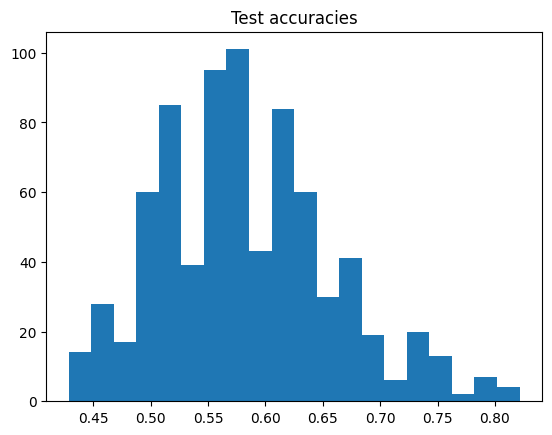

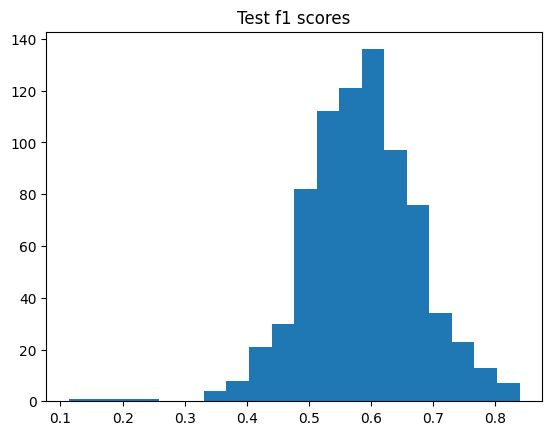

In [56]:
# plot histograms of the test accuracies and f1 scores
plt.hist(all_test_accs, bins=20)
plt.title('Test accuracies')
plt.show()

plt.hist(all_test_f1s, bins=20)
plt.title('Test f1 scores')
plt.show()

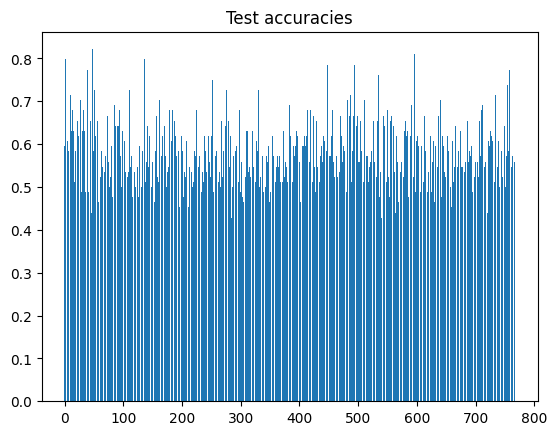

In [57]:
# plot bar chart of the accuracies across all 768 axes
plt.bar(range(768), all_test_accs)
plt.title('Test accuracies')
plt.show()

In [58]:
print(all_test_accs[:10]) 

[0.5952380952380952, 0.6547619047619048, 0.7976190476190477, 0.5357142857142857, 0.6071428571428571, 0.6071428571428571, 0.5238095238095238, 0.5833333333333334, 0.5357142857142857, 0.5238095238095238]


In [59]:
# convert list of tensors into list of floats
all_test_accs_val = [acc.item() for acc in all_test_accs]
all_test_f1s_val = [f1.item() for f1 in all_test_f1s]

print(all_test_accs_val[:10])
print(all_test_f1s_val[:10])

[0.5952380952380952, 0.6547619047619048, 0.7976190476190477, 0.5357142857142857, 0.6071428571428571, 0.6071428571428571, 0.5238095238095238, 0.5833333333333334, 0.5357142857142857, 0.5238095238095238]
[0.6730769230769231, 0.6813186813186813, 0.7951807228915663, 0.5411764705882354, 0.5714285714285715, 0.5925925925925927, 0.5918367346938775, 0.6067415730337079, 0.5185185185185186, 0.5]


In [60]:
# convert the lists into numpy arrays
all_test_accs_val = np.array(all_test_accs_val)
all_test_f1s_val = np.array(all_test_f1s_val)
all_combined_losses = np.array(all_combined_losses)

## Identify top 10 axes by accuracy

In [61]:
# find the indices of the top 10 slices
top_10_indices = np.argsort(all_test_accs_val)[-10:]
top_10_indices_f1 = np.argsort(all_test_f1s_val)[-10:]
print("Top 10 indices by accuracy", top_10_indices)
print("Top 10 indices by f1 score", top_10_indices_f1)

# find the metrics of the top 10 axes based on ACCURACY index 
print("Accuracy for top 10 (accuracy)", all_test_accs_val[top_10_indices])
print("F1 Scores for top 10 (accuracy)", all_test_f1s_val[top_10_indices])
print("Losses for top 10 (accuracy)", all_combined_losses[top_10_indices])

Top 10 indices by accuracy [494 448 321 136 641   2 596  48 549 614]
Top 10 indices by f1 score [448   2  21 136 641 321 549 596  48 614]
Accuracy for top 10 (accuracy) [0.78571429 0.78571429 0.79761905 0.79761905 0.79761905 0.79761905
 0.80952381 0.82142857 0.82142857 0.82142857]
F1 Scores for top 10 (accuracy) [0.7804878  0.78571429 0.80898876 0.8045977  0.8045977  0.79518072
 0.82222222 0.82758621 0.81927711 0.83870968]
Losses for top 10 (accuracy) [ 9.83395731  9.89088577  9.11257699 12.62065798  9.984496   10.56236261
 11.83186939  8.77105115  9.30406782 10.99429539]


In [62]:
# create a dataframe with accuracy and loss across all 768 axes
df_acc_loss = pd.DataFrame({
    'accuracy': all_test_accs_val,
    'f1': all_test_f1s,
    'loss': all_combined_losses
})

print(df_acc_loss[:10])

# save the dataframe to a csv file
df_acc_loss.to_csv(f"llm-outputs/{classification}_{timestamp}_xl_bruteforce_acc_loss.csv", index=False)

   accuracy        f1       loss
0  0.595238  0.673077  14.556726
1  0.654762  0.681319  14.250724
2  0.797619  0.795181  10.562363
3  0.535714  0.541176  13.960450
4  0.607143  0.571429  14.067435
5  0.607143  0.592593  14.420442
6  0.523810  0.591837  14.552403
7  0.583333  0.606742  13.904401
8  0.535714  0.518519  13.615988
9  0.523810  0.500000  13.689054


## Analysis for top 10 axes

In [63]:
# for each of the top 10 slices,
# average the embeddings of the pro words and the non words
# WHY: to see if there is a larger difference for axes that are more predictive

pro_emb_avg = []
non_emb_avg = []

for i in top_10_indices:
    df_slice = pd.DataFrame({
        # 'word': df_train['word'],
        'embedding': df_train[str(i)],
        'label': df_train['label']
    })

    df_slice_pro = df_slice[df_slice['label'] == 1]
    df_slice_non = df_slice[df_slice['label'] == 0]

    pro_emb_avg.append(np.mean(df_slice_pro['embedding']))
    non_emb_avg.append(np.mean(df_slice_non['embedding']))

# create a dataframe with the average embeddings
df_top10_avg = pd.DataFrame({
    'index': top_10_indices,
    'pro': pro_emb_avg,
    'non': non_emb_avg,
    'diff': abs(np.array(pro_emb_avg) - np.array(non_emb_avg)),
    'acc': all_test_accs_val[top_10_indices],
    'f1': all_test_f1s_val[top_10_indices],
    'loss': all_combined_losses[top_10_indices]
})

print(df_top10_avg)

# save the dataframe to a csv file
df_top10_avg.to_csv(f"llm-outputs/{classification}_{timestamp}_xl_bruteforce_top10_metrics.csv", index=False)

   index       pro       non      diff       acc        f1       loss
0    494 -0.137105 -0.571638  0.434534  0.785714  0.780488   9.833957
1    448  0.045637  0.375992  0.330355  0.785714  0.785714   9.890886
2    321  0.047781  0.376606  0.328825  0.797619  0.808989   9.112577
3    136  0.039955  0.261677  0.221722  0.797619  0.804598  12.620658
4    641  0.072267  0.407935  0.335668  0.797619  0.804598   9.984496
5      2 -0.331565 -0.014509  0.317056  0.797619  0.795181  10.562363
6    596  0.078355 -0.125956  0.204311  0.809524  0.822222  11.831869
7     48  0.388659 -0.168655  0.557313  0.821429  0.827586   8.771051
8    549  0.029448 -0.356181  0.385629  0.821429  0.819277   9.304068
9    614 -0.064818  0.134111  0.198929  0.821429  0.838710  10.994295


In [64]:
# Plot the histogram of the embedding values for the top 10 axes
# WHY: to see the relationship between the distribution of the positive and negative classes

def plot_axis_hist(slice):
    df_slice = pd.DataFrame({
        # 'word': df_train['word'],
        'embedding': df_train[str(slice)],
        'label': df_train['label']
    })

    df_slice_pro = df_slice[df_slice['label'] == 1]
    df_slice_non = df_slice[df_slice['label'] == 0]

    # draw a histogram of the embeddings, with the pro words in red and the non-pro words in blue
    plt.hist(df_slice_pro['embedding'], bins=30, color='red', alpha=0.5)
    plt.hist(df_slice_non['embedding'], bins=30, color='blue', alpha=0.5)
    plt.title(f"Axis {slice} histogram")
    plt.show()

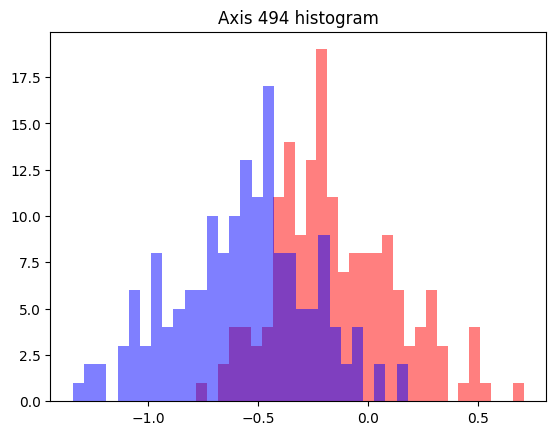

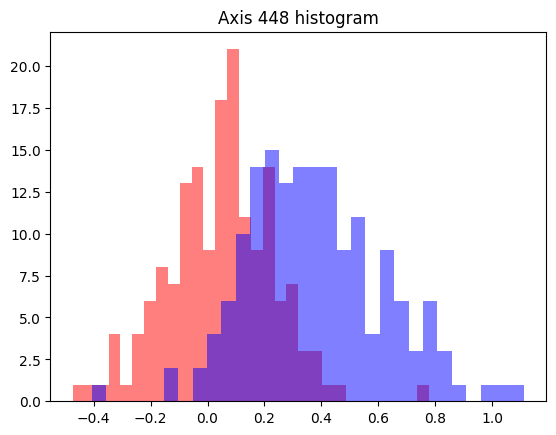

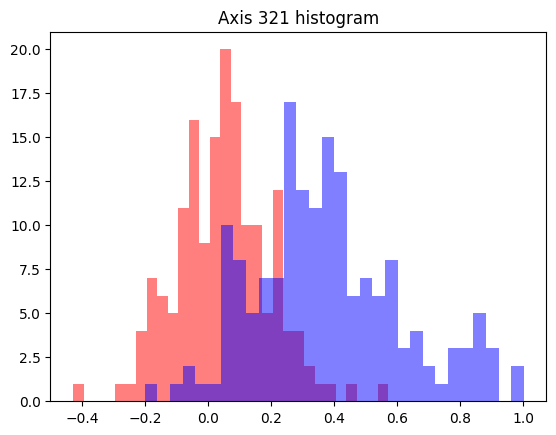

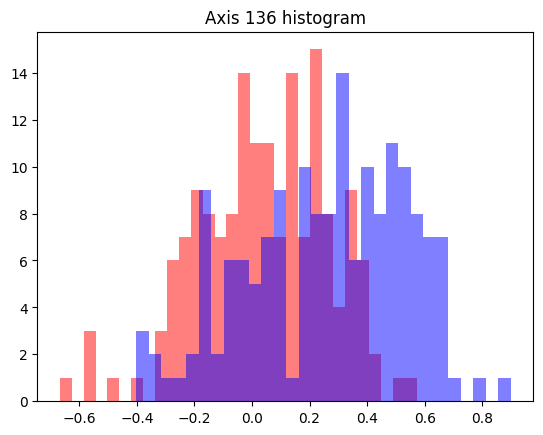

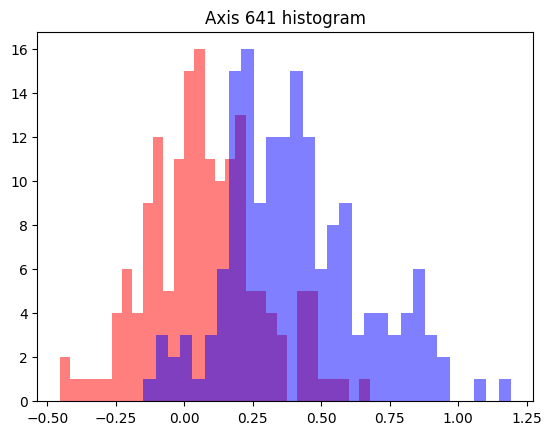

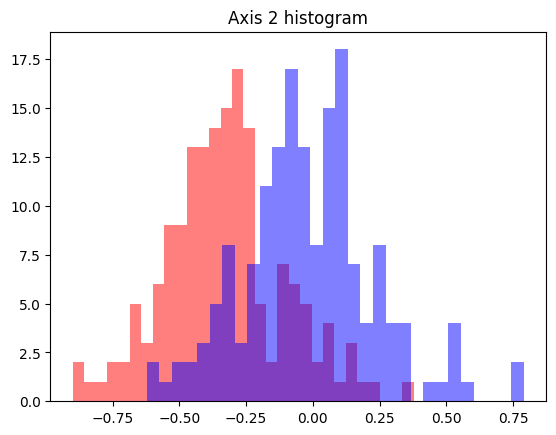

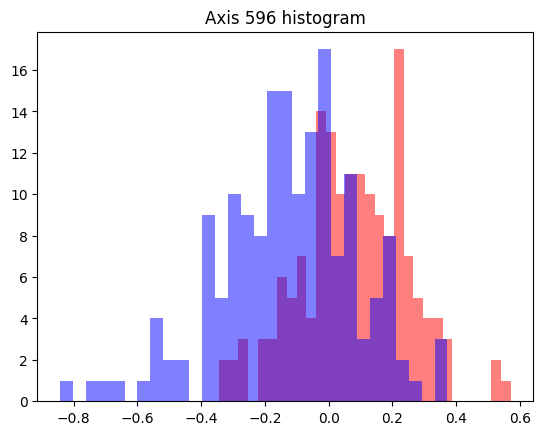

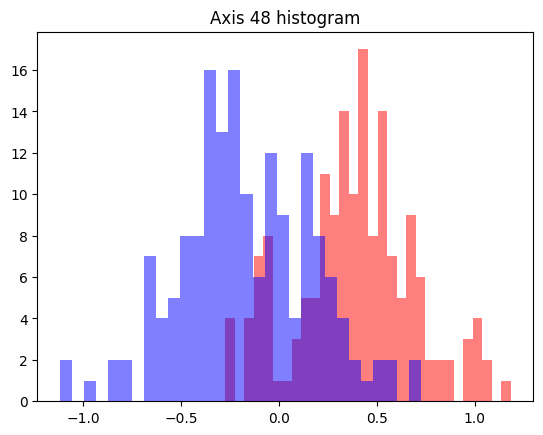

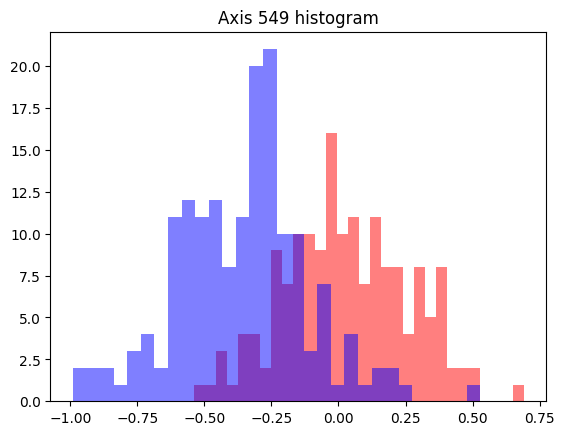

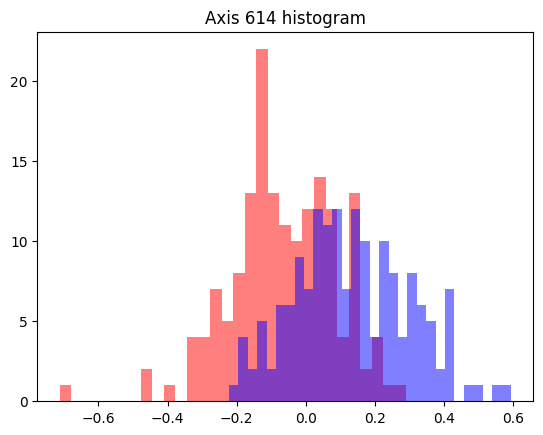

In [65]:
for i in top_10_indices:
    plot_axis_hist(i)

## Evaluate axes at 3 different scales (1s, 10s, 100s)

In [66]:
def run_model_on_defined_subslice(subslice, top_or_complement):
    if top_or_complement:
        subslice_indices = np.argsort(all_test_accs_val)[-subslice:]
        desc = "top"
    else:
        subslice_indices = np.argsort(all_test_accs_val)[:-subslice]
        subslice = 768 - subslice
        desc = "complement"

    df_subslice_train = pd.DataFrame(df_train[str(i)] for i in subslice_indices)
    df_subslice_train = df_subslice_train.T

    # combine all column values into list stored in one column
    df_subslice_train['embedding'] = df_subslice_train.values.tolist()

    # remove all columns except the list of embeddings
    df_subslice_train = df_subslice_train[['embedding']]
    df_subslice_train['label'] = df_train['label']
    df_subslice_train['word'] = df_train['word']

    print(df_subslice_train[:10])
    print(len(df_subslice_train['embedding'][0]))

    df_subslice_test = pd.DataFrame(df_test[str(i)] for i in subslice_indices)
    df_subslice_test = df_subslice_test.T

    # combine all column values into list stored in one column
    df_subslice_test['embedding'] = df_subslice_test.values.tolist()

    # remove all columns except the list of embeddings
    df_subslice_test = df_subslice_test[['embedding']]
    df_subslice_test['label'] = df_test['label']
    df_subslice_test['word'] = df_test['word']

    print(df_subslice_test[:10])
    print(len(df_subslice_test['embedding'][0]))

    subslice_train_loader, subslice_test_loader = create_dataloaders(df_subslice_train, df_subslice_test)

    # take the best of 3 runs
    subslice_best_test_acc = 0
    subslice_best_test_f1 = 0

    for i in range(num_loop):
        net, subslice_best_combined_loss = train_model(subslice_train_loader, subslice)

        # train_acc, train_f1 = evaluate_net(subslice_train_loader, net)
        test_acc, test_f1 = evaluate_net(subslice_test_loader, net)

        if test_acc > subslice_best_test_acc and test_f1 > subslice_best_test_f1:
            subslice_best_test_acc = test_acc
            subslice_best_test_f1 = test_f1

    print(f'{desc} {subslice} axes best combined loss: {subslice_best_combined_loss}')
    print(f'{desc} {subslice} axes best test f1: {subslice_best_test_f1:.4f}')
    print(f'{desc} {subslice} axes best test accuracy: {subslice_best_test_acc*100:.2f}% \n')

    return subslice_best_test_acc, subslice_best_test_f1, subslice_best_combined_loss


In [67]:
def run_defined_subslice_for_scale(scale):
    subslice_top_accs = []
    subslice_top_f1s = []
    subslice_top_losses = []

    subslice_complement_accs = []
    subslice_complement_f1s = []
    subslice_complement_losses = []

    if scale < 100:
        range_val = 10
    else:
        range_val = 4

    for i in range(range_val):
        acc, f1, loss = run_model_on_defined_subslice((i+1)*scale, True)
        subslice_top_accs.append(acc)
        subslice_top_f1s.append(f1)
        subslice_top_losses.append(loss)

    for i in range(range_val):
        acc, f1, loss = run_model_on_defined_subslice((i+1)*scale, False)
        subslice_complement_accs.append(acc)
        subslice_complement_f1s.append(f1)
        subslice_complement_losses.append(loss)

    if scale >= 100:
        acc, f1, loss = run_model_on_defined_subslice(768, True)
        subslice_top_accs.append(acc)
        subslice_top_f1s.append(f1)
        subslice_top_losses.append(loss)

        subslice_complement_accs.append(0)
        subslice_complement_f1s.append(0)
        subslice_complement_losses.append(0)

    if scale < 100:
        subslice_top_vals = [((i+1)*scale) for i in range(range_val)]
    else:
        subslice_top_vals = [((i+1)*scale) for i in range(range_val)]+[768]

    # plot the top and complement accuracies for scale 1 as two lines on the same plot
    # shift the x axis by 1 to account for the fact that the first subslice is 1
    if scale < 100:
        plt.plot(subslice_top_vals, subslice_top_accs, label='top')
        plt.plot(subslice_top_vals, subslice_complement_accs, label='complement')
    else:
        plt.plot(subslice_top_vals, subslice_top_accs, label='top')
        plt.plot(subslice_top_vals, subslice_complement_accs, label='complement')
    plt.title(f'Top and complement accuracies for scale {scale}')
    plt.xlabel('Number of axes')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # create df for scale 1 top and complement metrics
    df_subslice = pd.DataFrame({
        'subslice': subslice_top_vals,
        'acc_top': subslice_top_accs,
        'acc_complement': subslice_complement_accs,
        'f1_top': subslice_top_f1s,
        'f1_complement': subslice_complement_f1s,
        'loss_top': subslice_top_losses,
        'loss_complement': subslice_complement_losses
    })

    # save the dataframe to a csv file
    df_subslice.to_csv(f"llm-outputs/{classification}_{timestamp}_xl_bruteforce_s{scale}_top_metrics.csv", index=False)

    return subslice_top_accs, subslice_top_f1s, subslice_top_losses, subslice_complement_accs, subslice_complement_f1s, subslice_complement_losses

                 embedding  label         word
0    [-0.0690094530582428]      1       monkey
1   [-0.02898664027452469]      1   chimpanzee
2   [-0.10909323394298553]      1     reindeer
3   [-0.16420674324035645]      1        trout
4    [-0.2561110258102417]      1     crayfish
5   [-0.10204705595970154]      1    alligator
6   [0.012443006038665771]      1     elephant
7    [-0.2936377227306366]      1       spider
8  [-0.057934895157814026]      1  grasshopper
9   [-0.03957680985331535]      1       ocelot
1
                 embedding  label          word
0  [-0.015392214059829712]      1          hawk
1   [-0.06059914082288742]      1           owl
2   [-0.22346089780330658]      1         crane
3   [-0.19513759016990662]      1        wombat
4   [-0.06915738433599472]      1       gazelle
5  [-0.009137239307165146]      1           bat
6    [-0.2590034604072571]      1      kangaroo
7   [-0.12282976508140564]      1  sugar glider
8   [-0.13045112788677216]      1     cassowary
9

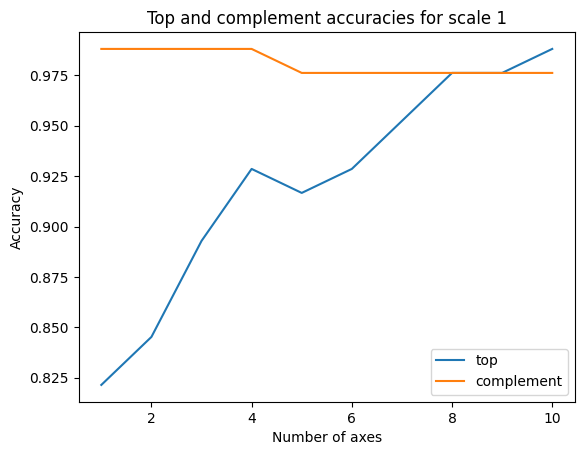

In [68]:
# run for scale = 1
s1_top_accs, s1_top_f1s, s1_top_losses, s1_complement_accs, s1_complement_f1s, s1_complement_losses = run_defined_subslice_for_scale(1)

                                           embedding  label         word
0  [-0.3665144741535187, 0.17642487585544586, -0....      1       monkey
1  [0.47244587540626526, 0.0021785981953144073, -...      1   chimpanzee
2  [-0.16255110502243042, 0.114569753408432, 0.12...      1     reindeer
3  [-0.28167814016342163, -0.3184811472892761, 0....      1        trout
4  [0.47684288024902344, 0.0366039052605629, -0.0...      1     crayfish
5  [-0.5540711879730225, -0.05893995612859726, 0....      1    alligator
6  [-0.1977470964193344, 0.05570220202207565, -0....      1     elephant
7  [-0.207086980342865, 0.16254983842372894, 0.00...      1       spider
8  [0.04715146869421005, 0.08646825700998306, -0....      1  grasshopper
9  [-0.18936051428318024, -0.07404472678899765, 0...      1       ocelot
10
                                           embedding  label          word
0  [-0.3349815905094147, -0.2873290777206421, 0.0...      1          hawk
1  [-0.09907940030097961, 0.1607958972454071, 

top 10 axes best combined loss: 2.5789206016343087
top 10 axes best test f1: 0.9767
top 10 axes best test accuracy: 97.62% 

                                           embedding  label         word
0  [-0.2987169027328491, -0.004257660359144211, -...      1       monkey
1  [-0.38987869024276733, -0.11997630447149277, 0...      1   chimpanzee
2  [-0.309275358915329, 0.032221291214227676, -0....      1     reindeer
3  [-0.23063434660434723, 0.08476662635803223, -0...      1        trout
4  [-0.4041254222393036, 0.4017447531223297, 0.20...      1     crayfish
5  [-0.42311885952949524, 0.10209323465824127, -0...      1    alligator
6  [-0.2084314227104187, 0.12659507989883423, -0....      1     elephant
7  [-0.18277710676193237, 0.14311158657073975, -0...      1       spider
8  [-0.6209250688552856, -0.11179161071777344, -0...      1  grasshopper
9  [-0.36391302943229675, 0.30592259764671326, 0....      1       ocelot
20
                                           embedding  label          

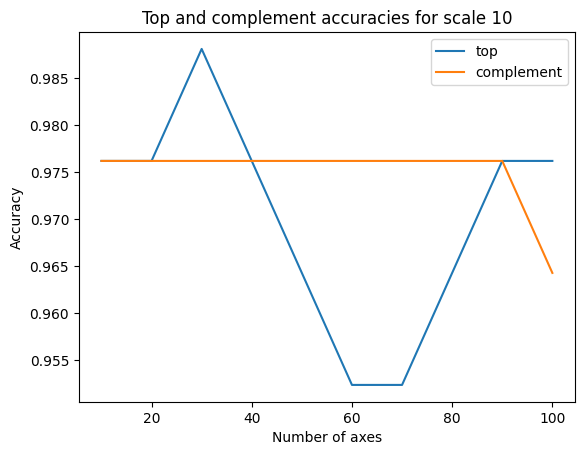

In [69]:
# run for scale = 10
s10_top_accs, s10_top_f1s, s10_top_losses, s10_complement_accs, s10_complement_f1s, s10_complement_losses = run_defined_subslice_for_scale(10)

                                           embedding  label         word
0  [0.1325533092021942, 0.23675411939620972, -0.2...      1       monkey
1  [0.12608611583709717, -0.012893833220005035, -...      1   chimpanzee
2  [-0.1216423511505127, 0.20953777432441711, -0....      1     reindeer
3  [-0.10829607397317886, -0.06613890826702118, -...      1        trout
4  [0.016069969162344933, 0.21418939530849457, -0...      1     crayfish
5  [-0.030694736167788506, 0.20283566415309906, -...      1    alligator
6  [-0.0017907023429870605, 0.4993151128292084, -...      1     elephant
7  [0.024481821805238724, -0.057964131236076355, ...      1       spider
8  [-0.19608074426651, -0.09811855107545853, 0.01...      1  grasshopper
9  [0.263986736536026, -0.328817218542099, -0.686...      1       ocelot
100
                                           embedding  label          word
0  [-0.26943835616111755, -0.005494460463523865, ...      1          hawk
1  [-0.05861988663673401, 0.06650533527135849

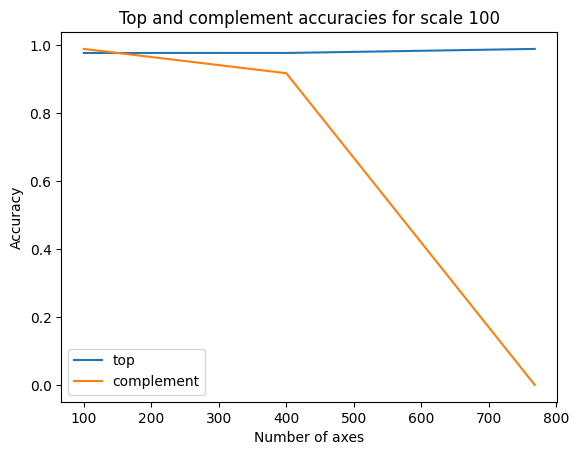

In [70]:
# run for scale = 100
s100_top_accs, s100_top_f1s, s100_top_losses, s100_complement_accs, s100_complement_f1s, s100_complement_losses = run_defined_subslice_for_scale(100)

In [105]:
# full_train_pos_prob = output_pos_prob(full_train_loader, full_best_net)
# full_test_pos_prob = output_pos_prob(full_test_loader, full_best_net)

# # create a dataframe with the words and their positive probabilities
# df_full_train_pos_prob = pd.DataFrame({
#     'word': df_full_train['word'],
#     'pos_prob': full_train_pos_prob,
#     'label': df_full_train['label']
# })

# df_full_test_pos_prob = pd.DataFrame({
#     'word': df_full_test['word'],
#     'pos_prob': full_test_pos_prob,
#     'label': df_full_test['label']
# })

# # combine the train and test dataframes
# df_full_pos_prob = pd.concat([df_full_train_pos_prob, df_full_test_pos_prob])

# print(df_full_pos_prob[:10])

# # save the dataframe to a csv file
# df_full_pos_prob.to_csv(f"llm-outputs/{classification}_{timestamp}_xl_bruteforce_full_pos_prob.csv", index=False)

          word      pos_prob  label
0        trout  3.393515e-08      1
1       jaguar  9.996065e-01      1
2       dunlin  2.661128e-08      1
3  caterpillar  6.885542e-07      1
4          eel  9.980862e-01      1
5     platypus  9.999986e-01      1
6         lynx  7.163551e-06      1
7         newt  6.429866e-03      1
8        crane  9.975756e-01      1
9       numbat  9.999999e-01      1


❗️ [ ] Add dotted line 768 axes as baseline